In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# 常用超参数
batch_size = 128
learning_rate = 0.001
num_epochs = 10
topk_ratios = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
angles = [15, 30, 45, 60]

# 数据标准化
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

# 原始数据集
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 加载原始训练和测试集
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 为每个角度生成旋转数据集
train_rot_loaders = {}
test_rot_loaders = {}

for angle in angles:
    transform_train_rot = transforms.Compose([
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test_rot = transforms.Compose([
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_dataset_rot = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train_rot, download=True)
    test_dataset_rot = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test_rot, download=True)

    train_rot_loaders[angle] = DataLoader(train_dataset_rot, batch_size=batch_size, shuffle=True)
    test_rot_loaders[angle] = DataLoader(test_dataset_rot, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [4]:
def train_model(model, train_loader, epochs, save_path):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss/100:.3f}')
                running_loss = 0.0
    torch.save(model.state_dict(), save_path)
    return model

In [5]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [6]:
def create_merged_net(net1, delta_params, topk_ratio):
    merged_net = Net().to(device)
    merged_state = {}
    for key in net1.state_dict().keys():
        net1_param = net1.state_dict()[key].clone()
        delta = delta_params[key]
        abs_delta = delta.abs()
        total_params = abs_delta.numel()
        topk_num = int(total_params * topk_ratio)
        if topk_num == 0:
            topk_num = 1

        # 构建 mask
        flattened_abs = abs_delta.view(-1)
        values, indices = flattened_abs.topk(topk_num)
        mask = torch.zeros_like(flattened_abs)
        mask[indices] = 1
        mask = mask.view(abs_delta.shape).to(device)

        # 应用 mask
        sparse_delta = delta * mask
        merged_param = net1_param + sparse_delta
        merged_state[key] = merged_param

    merged_net.load_state_dict(merged_state)
    return merged_net

Training net2 for 15 degrees...
Epoch 1, Batch 100, Loss: 1.094
Epoch 1, Batch 200, Loss: 0.799
Epoch 1, Batch 300, Loss: 0.756
Epoch 2, Batch 100, Loss: 0.528
Epoch 2, Batch 200, Loss: 0.543
Epoch 2, Batch 300, Loss: 0.546
Epoch 3, Batch 100, Loss: 0.368
Epoch 3, Batch 200, Loss: 0.398
Epoch 3, Batch 300, Loss: 0.394
Epoch 4, Batch 100, Loss: 0.247
Epoch 4, Batch 200, Loss: 0.273
Epoch 4, Batch 300, Loss: 0.292
Epoch 5, Batch 100, Loss: 0.163
Epoch 5, Batch 200, Loss: 0.188
Epoch 5, Batch 300, Loss: 0.196
Epoch 6, Batch 100, Loss: 0.108
Epoch 6, Batch 200, Loss: 0.110
Epoch 6, Batch 300, Loss: 0.120
Epoch 7, Batch 100, Loss: 0.082
Epoch 7, Batch 200, Loss: 0.080
Epoch 7, Batch 300, Loss: 0.086
Epoch 8, Batch 100, Loss: 0.071
Epoch 8, Batch 200, Loss: 0.067
Epoch 8, Batch 300, Loss: 0.074
Epoch 9, Batch 100, Loss: 0.055
Epoch 9, Batch 200, Loss: 0.063
Epoch 9, Batch 300, Loss: 0.071
Epoch 10, Batch 100, Loss: 0.049
Epoch 10, Batch 200, Loss: 0.044
Epoch 10, Batch 300, Loss: 0.073
Evalu

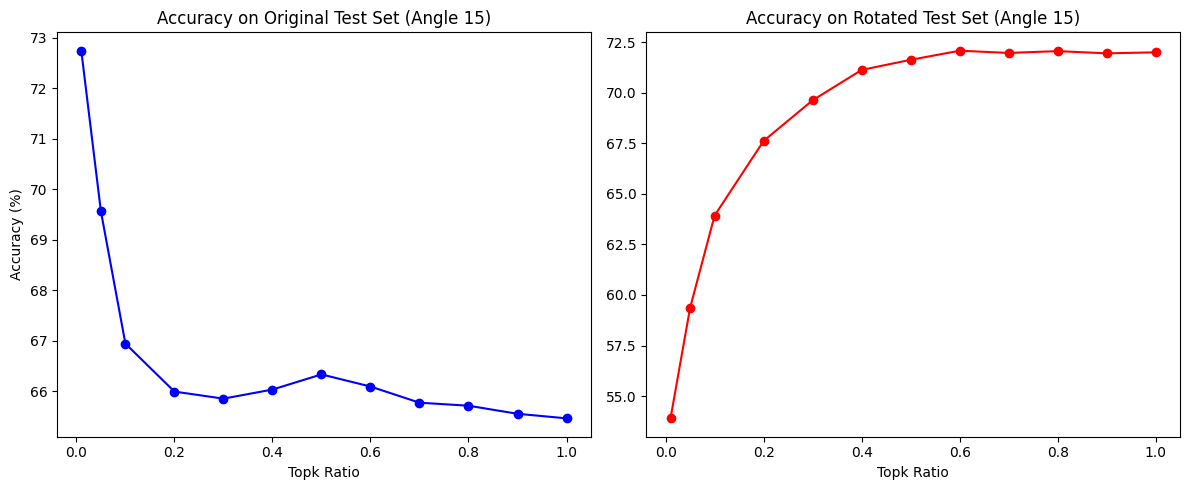

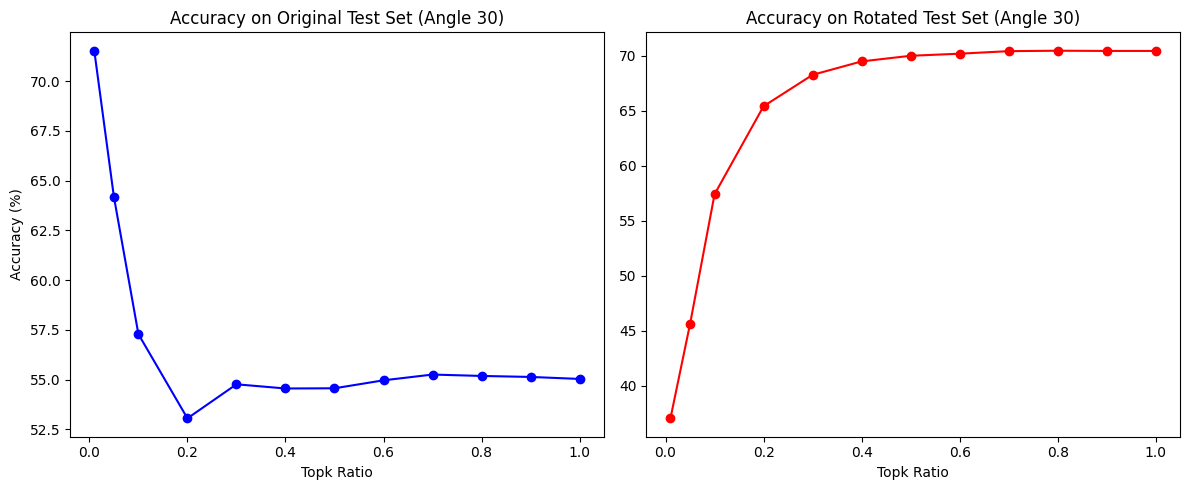

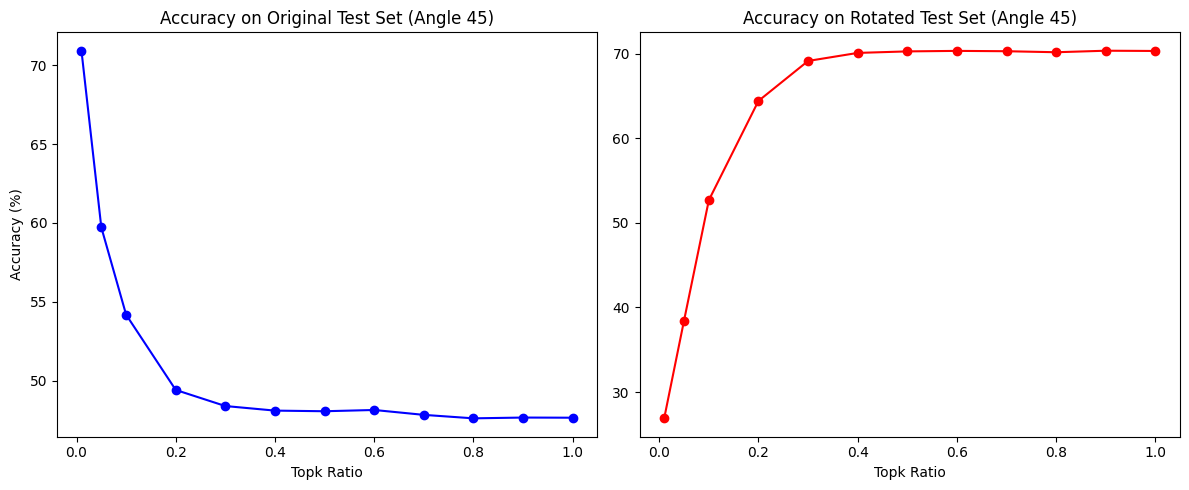

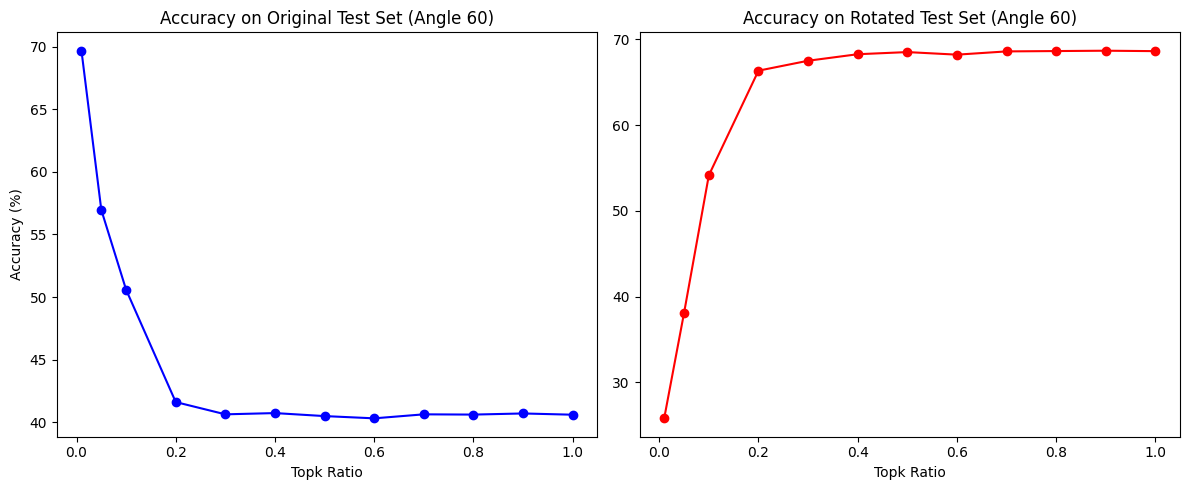

In [7]:
# 1. 训练并保存 net1
if not os.path.exists('net1.pth'):
    net1 = Net().to(device)
    print("Training net1...")
    net1 = train_model(net1, train_loader, num_epochs, 'net1.pth')
else:
    net1 = Net().to(device)
    net1.load_state_dict(torch.load('net1.pth'))

# 2. 对每个角度训练 net2 并生成融合模型
results_by_angle = {}

for angle in angles:
    save_path = f'net2_{angle}.pth'
    if not os.path.exists(save_path):
        net2 = Net().to(device)
        net2.load_state_dict(torch.load('net1.pth'))
        print(f"Training net2 for {angle} degrees...")
        net2 = train_model(net2, train_rot_loaders[angle], num_epochs, save_path)
    else:
        net2 = Net().to(device)
        net2.load_state_dict(torch.load(save_path))

    # 3. 计算 delta
    delta_params = {}
    for key in net1.state_dict().keys():
        delta = net2.state_dict()[key] - net1.state_dict()[key]
        delta_params[key] = delta

    # 4. 评估不同 topk 比率
    results = []
    print(f"Evaluating merged models for {angle} degrees...")
    for topk in topk_ratios:
        merged_net = create_merged_net(net1, delta_params, topk)
        acc_orig = evaluate_model(merged_net, test_loader)
        acc_rot = evaluate_model(merged_net, test_rot_loaders[angle])
        results.append((topk, acc_orig, acc_rot))
        print(f"Angle {angle}, Topk={topk:.2f}: Original={acc_orig:.1f}%, Rotated={acc_rot:.1f}%")

    results_by_angle[angle] = results

# 5. 可视化每个角度的结果
for angle in angles:
    results = np.array(results_by_angle[angle])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(results[:, 0], results[:, 1], 'bo-')
    plt.title(f'Accuracy on Original Test Set (Angle {angle})')
    plt.xlabel('Topk Ratio')
    plt.ylabel('Accuracy (%)')

    plt.subplot(1, 2, 2)
    plt.plot(results[:, 0], results[:, 2], 'ro-')
    plt.title(f'Accuracy on Rotated Test Set (Angle {angle})')
    plt.xlabel('Topk Ratio')

    plt.tight_layout()
    plt.savefig(f'results_angle_{angle}.png')
    plt.show()

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# 训练 MTL Oracle
def train_mtl_model(angles, model, train_rot_loaders):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        total_loss = 0
        for angle in angles:
            for inputs, labels in train_rot_loaders[angle]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        print(f"Epoch {epoch+1} | MTL Loss: {total_loss:.2f}")

    return model

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [16]:
# 假设已导入必要的库（如 torch, numpy, matplotlib 等）

# 修改后的 train_continual_learning 函数（返回各任务准确率）
def train_continual_learning(angles, model, train_rot_loaders, test_rot_loaders, use_task_vectors=True):
    model = model.to(device)
    task_models = []  # 保存每个任务结束时的模型
    task_accuracies = []  # 保存每个任务的准确率
    task_vectors = []

    # Step 1: 训练 MTL Oracle
    mtl_model = train_mtl_model(angles, copy.deepcopy(model), train_rot_loaders)

    # Step 2: 依次训练每个任务
    for i, angle in enumerate(angles):
        print(f"\nTraining Task {i+1} (Rotation {angle}°)")
        train_loader = train_rot_loaders[angle]
        test_loader = test_rot_loaders[angle]

        # 微调当前模型
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(5):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # 评估当前模型在当前任务上的性能
        acc = evaluate_model(model, test_loader)
        task_accuracies.append(acc)
        print(f"Task {i+1} Accuracy: {acc:.2f}%")

        # 保存当前模型
        task_models.append(copy.deepcopy(model))

        # 如果使用任务向量方法，计算并存储任务向量
        if use_task_vectors and i > 0:
            prev_model = task_models[i - 1]
            delta = {}
            for key in model.state_dict().keys():
                delta[key] = model.state_dict()[key] - prev_model.state_dict()[key]
            task_vectors.append(delta)

    # Step 3: 最终模型在所有任务上的表现（用于 Forget 指标）
    final_loss = 0.0
    mtl_loss = 0.0
    with torch.no_grad():
        for angle in angles:
            test_loader = test_rot_loaders[angle]
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                final_loss += criterion(model(inputs), labels).item()
                mtl_loss += criterion(mtl_model(inputs), labels).item()

    forget = final_loss - mtl_loss
    avg_accuracy = sum(task_accuracies) / len(task_accuracies)

    # 返回任务准确率列表、Forget 和 Average Accuracy
    return task_accuracies, forget, avg_accuracy

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Using existing net1.
Using existing MTL model.
Using existing Fine-tuning models.
Using existing Task Vectors models.
Evaluating Fine-tuning models on all tasks...
Evaluating Task Vectors models on all tasks...

Fine-tuning Model Accuracies on Past Tasks:
Task 1 Model: [72.55]
Task 2 Model: [67.77, 72.22]
Task 3 Model: [50.5, 67.59, 72.34]
Task 4 Model: [31.16, 49.37, 68.19, 71.85]

Task Vectors Model Accuracies on Past Tasks:
Task 1 Model: [66.23]
Task 2 Model: [61.7, 58.01]
Task 3 Model: [47.11, 54.77, 47.93]
Task 4 Model: [30.35, 40.22, 39.83, 41.44]


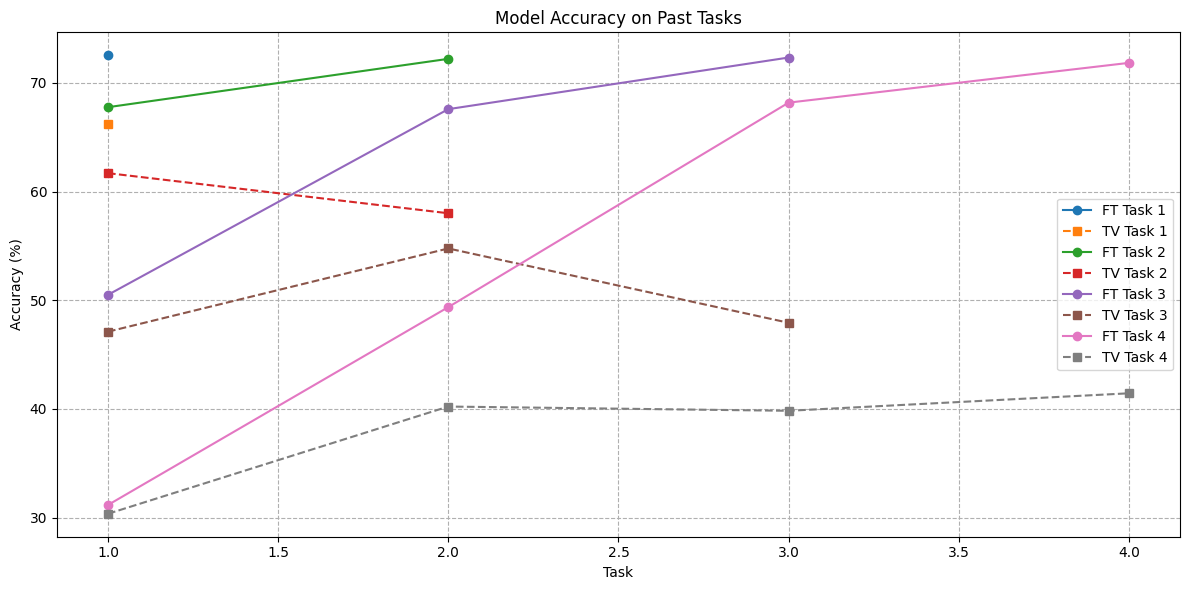

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import copy

# 设置设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 超参数
batch_size = 128
learning_rate = 1e-3
num_epochs_ft = 5  # 每个任务微调轮数
num_epochs_mtl = 10  # MTL 训练轮数
topk_ratio = 0.1  # 稀疏化比例（Top-10%）
angles = [15, 30, 45, 60]  # 任务角度

# 数据标准化参数
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

# 数据预处理函数
def get_transform(angle):
    return transforms.Compose([
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

# 加载原始数据（未旋转）
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 加载旋转任务数据
train_rot_loaders = {}
test_rot_loaders = {}
for angle in angles:
    train_dataset_rot = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transform(angle))
    test_dataset_rot = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transform(angle))
    train_rot_loaders[angle] = DataLoader(train_dataset_rot, batch_size=batch_size, shuffle=True)
    test_rot_loaders[angle] = DataLoader(test_dataset_rot, batch_size=batch_size, shuffle=False)

# 网络定义（与训练时一致）
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# 评估函数
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# 训练原始模型（net1）
def train_net1():
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs_ft):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), 'net1.pth')
    return model

# 加载原始模型（net1）
def load_net1():
    model = Net().to(device)
    model.load_state_dict(torch.load('net1.pth', map_location=device))
    return model

# 训练 MTL 模型（只训练一次）
def train_mtl_model():
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 合并所有任务的训练数据
    all_data = []
    for angle in angles:
        all_data.extend(train_rot_loaders[angle].dataset)
    dataloader = DataLoader(all_data, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs_mtl):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    torch.save(model.state_dict(), 'mtl_model.pth')
    return model

# 加载 MTL 模型
def load_mtl_model():
    model = Net().to(device)
    model.load_state_dict(torch.load('mtl_model.pth', map_location=device))
    return model

# 微调方法（基于前一个任务模型继续训练）
def fine_tuning_sequential():
    # 加载基础模型
    model = load_net1()
    trained_models = [model]
    
    # 依次训练每个任务
    for i, angle in enumerate(angles):
        print(f"Training Task {i+1} (Rotation {angle}°)")
        train_loader = train_rot_loaders[angle]
        test_loader = test_rot_loaders[angle]
        
        # 微调当前模型
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs_ft):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 保存当前模型
        torch.save(model.state_dict(), f'ft_task{i+1}.pth')
        trained_models.append(copy.deepcopy(model))
    
    return trained_models

# 任务向量方法（独立训练任务模型，稀疏化后拼接）
def task_vectors_sequential():
    # 加载基础模型
    net1 = load_net1()
    trained_models = [copy.deepcopy(net1)]
    
    # 存储任务向量
    task_vectors = []
    
    # 独立训练每个任务模型
    for i, angle in enumerate(angles):
        print(f"Training Task {i+1} (Rotation {angle}°)")
        train_loader = train_rot_loaders[angle]
        
        # 从 net1 初始化新模型
        model = copy.deepcopy(net1)
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs_ft):
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 保存任务模型
        torch.save(model.state_dict(), f'tv_task{i+1}_raw.pth')
        
        # 计算任务向量
        vec = {}
        for key in model.state_dict().keys():
            vec[key] = model.state_dict()[key] - net1.state_dict()[key]
        task_vectors.append(vec)
    
    # 稀疏化任务向量
    sparse_vectors = []
    for i, vec in enumerate(task_vectors):
        sparse_vec = {}
        for key in vec.keys():
            # 获取参数绝对值
            abs_vals = vec[key].abs()
            total_params = abs_vals.numel()
            topk_num = int(total_params * topk_ratio)  # Top-k%
            if topk_num == 0:
                topk_num = 1
            
            # 创建 mask
            flattened_abs = abs_vals.view(-1)
            _, indices = flattened_abs.topk(topk_num)
            mask = torch.zeros_like(flattened_abs)
            mask[indices] = 1
            mask = mask.view(abs_vals.shape).to(device)
            
            # 应用 mask
            sparse_vec[key] = vec[key] * mask
        
        sparse_vectors.append(sparse_vec)
    
    # 任务向量拼接
    model = copy.deepcopy(net1)
    trained_models = [model]
    
    for i, sparse_vec in enumerate(sparse_vectors):
        print(f"Applying Task Vector {i+1}")
        # 更新模型参数
        state = model.state_dict()
        for key in state.keys():
            state[key] += sparse_vec[key]
        model.load_state_dict(state)
        
        # 保存当前模型
        torch.save(model.state_dict(), f'tv_task{i+1}_sparse.pth')
        trained_models.append(copy.deepcopy(model))
    
    return trained_models

# 计算 Forget 指标（基于固定 MTL 模型）
def compute_forget(model):
    mtl_model = load_mtl_model()
    criterion = nn.CrossEntropyLoss()
    final_loss = 0.0
    mtl_loss = 0.0

    with torch.no_grad():
        for angle in angles:
            test_loader = test_rot_loaders[angle]
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                final_loss += criterion(model(inputs), labels).item()
                mtl_loss += criterion(mtl_model(inputs), labels).item()

    return final_loss - mtl_loss

# 评估过往任务准确率
# 修改后的评估函数，支持任务向量模型的文件名规则
def evaluate_all_tasks(model_name_prefix, num_tasks, is_task_vector=False):
    acc_matrix = []

    for i in range(1, num_tasks + 1):
        # 判断是否为任务向量模型，决定文件名格式
        if is_task_vector:
            model_path = f'{model_name_prefix}_task{i}_sparse.pth'
        else:
            model_path = f'{model_name_prefix}_task{i}.pth'
        
        # 加载模型
        model = Net().to(device)
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
        except FileNotFoundError:
            print(f"Model file not found: {model_path}")
            continue
        model.eval()

        # 评估过往任务
        task_accs = []
        for j in range(i):
            test_loader = test_rot_loaders[angles[j]]
            acc = evaluate_model(model, test_loader)
            task_accs.append(acc)

        acc_matrix.append(task_accs)

    return acc_matrix

# 主流程
if not os.path.exists('net1.pth'):
    print("Training net1...")
    train_net1()
else:
    print("Using existing net1.")

if not os.path.exists('mtl_model.pth'):
    print("Training MTL model...")
    train_mtl_model()
else:
    print("Using existing MTL model.")

# 微调方法
if not all(os.path.exists(f'ft_task{i+1}.pth') for i in range(len(angles))):
    print("Training Fine-tuning models...")
    fine_tuning_sequential()
else:
    print("Using existing Fine-tuning models.")

# 任务向量方法
if not all(os.path.exists(f'tv_task{i+1}_sparse.pth') for i in range(len(angles))):
    print("Training Task Vectors models...")
    task_vectors_sequential()
else:
    print("Using existing Task Vectors models.")

# 微调方法评估
print("Evaluating Fine-tuning models on all tasks...")
ft_acc_matrix = evaluate_all_tasks('ft', len(angles), is_task_vector=False)

# 任务向量方法评估
print("Evaluating Task Vectors models on all tasks...")
tv_acc_matrix = evaluate_all_tasks('tv', len(angles), is_task_vector=True)
# 输出结果
print("\nFine-tuning Model Accuracies on Past Tasks:")
for i, accs in enumerate(ft_acc_matrix):
    print(f"Task {i+1} Model: {accs}")

print("\nTask Vectors Model Accuracies on Past Tasks:")
for i, accs in enumerate(tv_acc_matrix):
    print(f"Task {i+1} Model: {accs}")

# 可视化
x = range(len(angles))
width = 0.35

plt.figure(figsize=(12, 6))
for i in range(len(angles)):
    plt.plot([j + 1 for j in range(i+1)], ft_acc_matrix[i], marker='o', label=f'FT Task {i+1}')
    plt.plot([j + 1 for j in range(i+1)], tv_acc_matrix[i], marker='s', linestyle='--', label=f'TV Task {i+1}')

plt.xlabel('Task')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Past Tasks')
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

In [23]:
# 计算 Forget 指标（基于固定 MTL 模型）
def compute_forget(model):
    mtl_model = load_mtl_model()
    criterion = nn.CrossEntropyLoss()
    final_loss = 0.0
    mtl_loss = 0.0

    with torch.no_grad():
        for angle in angles:
            test_loader = test_rot_loaders[angle]
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                final_loss += criterion(model(inputs), labels).item()
                mtl_loss += criterion(mtl_model(inputs), labels).item()

    return final_loss - mtl_loss

# 计算 Average Accuracy（每个任务训练后的准确率）
def compute_average_accuracy(trained_models, test_rot_loaders):
    total_acc = 0.0
    num_tasks = len(trained_models)
    task_accuracies = []

    for i in range(num_tasks):
        model = trained_models[i]
        test_loader = test_rot_loaders[angles[i]]
        acc = evaluate_model(model, test_loader)
        task_accuracies.append(acc)
        total_acc += acc

    avg_accuracy = total_acc / num_tasks
    return avg_accuracy, task_accuracies

In [24]:
# 微调方法
if not all(os.path.exists(f'ft_task{i+1}.pth') for i in range(len(angles))):
    print("Training Fine-tuning models...")
    ft_models = fine_tuning_sequential()
else:
    print("Using existing Fine-tuning models.")
    ft_models = [load_net1()]
    for i in range(len(angles)):
        model = Net().to(device)
        model.load_state_dict(torch.load(f'ft_task{i+1}.pth', map_location=device))
        ft_models.append(model)

# 任务向量方法
if not all(os.path.exists(f'tv_task{i+1}_sparse.pth') for i in range(len(angles))):
    print("Training Task Vectors models...")
    tv_models = task_vectors_sequential()
else:
    print("Using existing Task Vectors models.")
    tv_models = [load_net1()]
    for i in range(len(angles)):
        model = Net().to(device)
        model.load_state_dict(torch.load(f'tv_task{i+1}_sparse.pth', map_location=device))
        tv_models.append(model)

# 评估过往任务准确率
print("Evaluating Fine-tuning models on all tasks...")
ft_acc_matrix = evaluate_all_tasks('ft', len(angles), is_task_vector=False)

print("Evaluating Task Vectors models on all tasks...")
tv_acc_matrix = evaluate_all_tasks('tv', len(angles), is_task_vector=True)

# 计算 Forget 和 Average Accuracy
final_ft_model = ft_models[-1]
final_tv_model = tv_models[-1]

forget_ft = compute_forget(final_ft_model)
forget_tv = compute_forget(final_tv_model)

avg_acc_ft, ft_task_accuracies = compute_average_accuracy(ft_models[1:], test_rot_loaders)
avg_acc_tv, tv_task_accuracies = compute_average_accuracy(tv_models[1:], test_rot_loaders)

# 输出结果
print("\nFine-tuning Model Accuracies on Past Tasks:")
for i, accs in enumerate(ft_acc_matrix):
    print(f"Task {i+1} Model: {accs}")

print("\nTask Vectors Model Accuracies on Past Tasks:")
for i, accs in enumerate(tv_acc_matrix):
    print(f"Task {i+1} Model: {accs}")

print(f"\nForget (Fine-tuning): {forget_ft:.2f}")
print(f"Forget (Task Vectors): {forget_tv:.2f}")
print(f"Average Accuracy (Fine-tuning): {avg_acc_ft:.2f}%")
print(f"Average Accuracy (Task Vectors): {avg_acc_tv:.2f}%")

Using existing Fine-tuning models.
Using existing Task Vectors models.
Evaluating Fine-tuning models on all tasks...
Evaluating Task Vectors models on all tasks...

Fine-tuning Model Accuracies on Past Tasks:
Task 1 Model: [72.55]
Task 2 Model: [67.77, 72.22]
Task 3 Model: [50.5, 67.59, 72.34]
Task 4 Model: [31.16, 49.37, 68.19, 71.85]

Task Vectors Model Accuracies on Past Tasks:
Task 1 Model: [66.23]
Task 2 Model: [61.7, 58.01]
Task 3 Model: [47.11, 54.77, 47.93]
Task 4 Model: [30.35, 40.22, 39.83, 41.44]

Forget (Fine-tuning): 775.61
Forget (Task Vectors): 987.46
Average Accuracy (Fine-tuning): 72.24%
Average Accuracy (Task Vectors): 53.40%


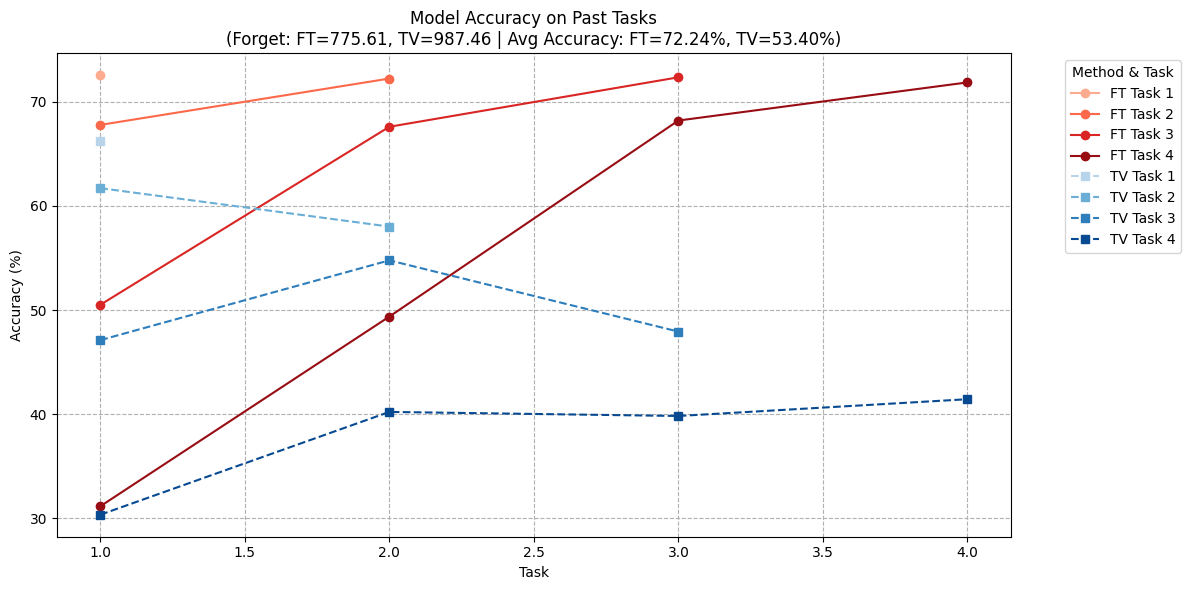

In [25]:
import matplotlib.pyplot as plt

# 生成颜色序列
num_tasks = len(angles)
tv_colors = plt.cm.Blues(np.linspace(0.3, 0.9, num_tasks))
ft_colors = plt.cm.Reds(np.linspace(0.3, 0.9, num_tasks))

# 绘图
plt.figure(figsize=(12, 6))

# Fine-tuning
for i in range(num_tasks):
    plt.plot(
        [j + 1 for j in range(i+1)], 
        ft_acc_matrix[i], 
        marker='o', 
        color=ft_colors[i], 
        label=f'FT Task {i+1}'
    )

# Task Vectors
for i in range(num_tasks):
    plt.plot(
        [j + 1 for j in range(i+1)], 
        tv_acc_matrix[i], 
        marker='s', 
        linestyle='--', 
        color=tv_colors[i], 
        label=f'TV Task {i+1}'
    )

# 图表注释
plt.xlabel('Task')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy on Past Tasks\n'
          f'(Forget: FT={forget_ft:.2f}, TV={forget_tv:.2f} | '
          f'Avg Accuracy: FT={avg_acc_ft:.2f}%, TV={avg_acc_tv:.2f}%)')
plt.legend(title='Method & Task', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()